## Experiment 5: 
### Show, Attend and Tell Network with Resnet101 Encoder, LSTM Decoder with Soft Attention and with Teacher Forcing

This notebook shows the training, validation and obtained results of the experiment created with show, attend and tell network.

__CONFIGURATION:__  
1. Encoder: Resnet101 (Dimension = 2048)
2. Decoder: LSTMCell + Deterministic Soft Attention
3. Teacher Forcing for Decoder Training: True
4. Optimizer: Adam
5. Loss function: Cross Entropy Loss
6. Regularization Constant (alpha_c): 1
7. Learning Rate: 4e-4
8. Step size for learning rate annealing: 5
9. Batch Size: 32
10. Number of epochs: 3

In [1]:
%matplotlib notebook
import json
import torch
import torch.utils.data as td
import torch.nn as nn
import torch.optim as optim
import os
from matplotlib import pyplot as plt

### Creation of the training, validation datasets and the word dictionary

In [2]:
from dataset import COCO14Dataset

data_root_dir = 'data/coco'

train_set = COCO14Dataset(None, data_root_dir) 
val_set = COCO14Dataset(None, data_root_dir, mode='val')

word_dict = json.load(open(data_root_dir + '/word_dict.json', 'r'))
vocabulary_size = len(word_dict)

### Verification of correct loading of the training dataset and corresponding captions

<IPython.core.display.Javascript object>


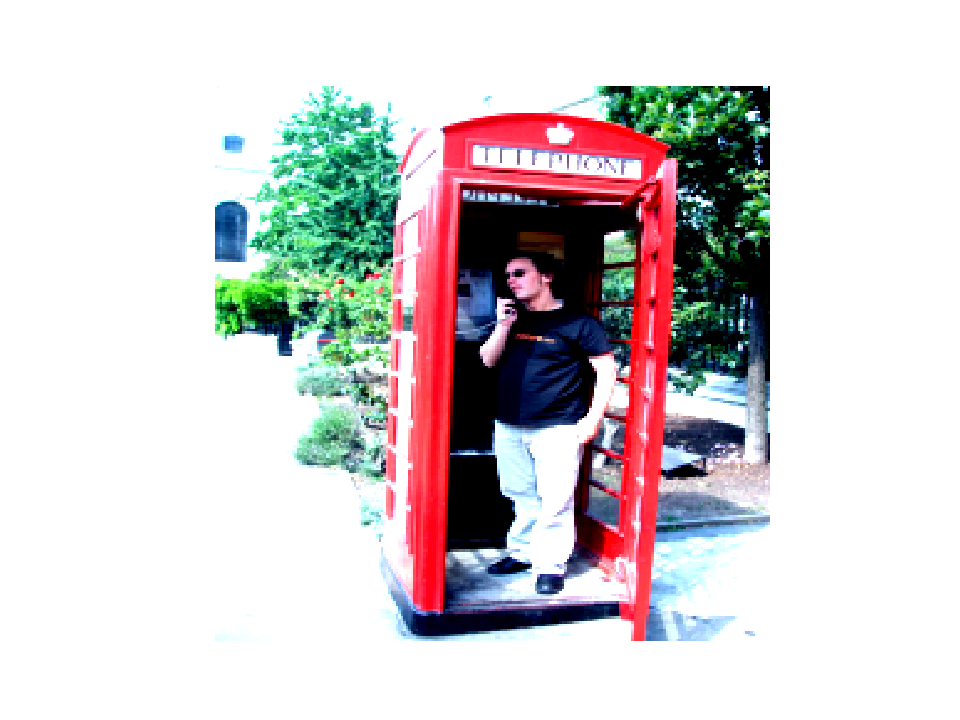

Correct Captions:
A big red telephone booth that a man is standing in.
A person standing inside of a phone booth.
This is an image of a man in a phone booth.
A man is standing in a red phone booth.
A man using a phone in a phone booth.


In [3]:
from utils import myimshow, generate_caption

h = myimshow(train_set[10][0])
print('Correct Captions:')
for i in range(5):
    print(generate_caption(train_set[10+i][1], word_dict))

### Verification of correct loading of the validation dataset and corresponding captions

<IPython.core.display.Javascript object>


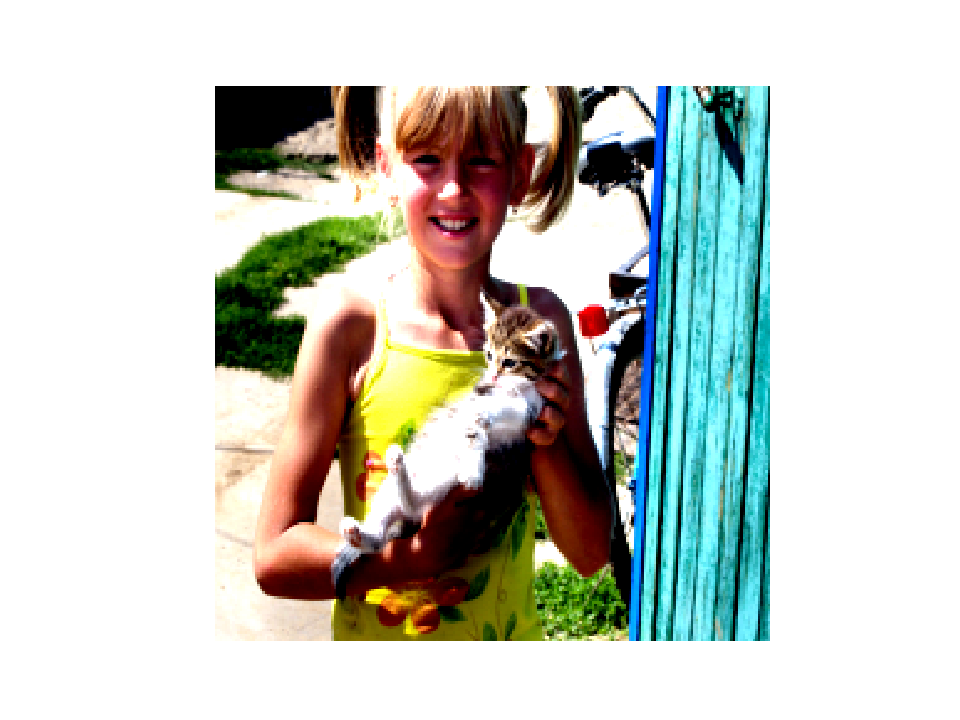

Correct Captions:
A little girl holding a kitten next to a blue fence.
Girl in a tank top holding a kitten in her back yard.
A young girl is holding a small cat.
Girl with a yellow shirt holding a small cat.
A girl smiles as she holds a kitty cat.


In [4]:
h = myimshow(val_set[10][0])
print('Correct Captions:')
for i in range(5):
    print(generate_caption(val_set[10][2][i], word_dict))

### Creation of all Dependencies for Experiment 5

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"device = {device}")

device = cuda


In [6]:
from models import Encoder, Decoder

network = 'resnet101'
tf_ratio = 0        # Teacher Forcing is used always
lr = 4e-4           # Learning rate
batch_size = 32     # Batch size for mini-batch gradient descent
step_size = 5       # Step size for learning rate annealing
alpha_c = 1         # Regularization constant
start_epoch = 1     # Starting epoch for the experiment
log_interval = 100  # Frequency for logging statistics

log_filename = 'logs/log_resnet101.txt'

In [7]:
encoder = Encoder(network).to(device)
decoder = Decoder(device, vocabulary_size, encoder.dim, tf_ratio = tf_ratio).to(device) 
optimizer = optim.Adam(decoder.parameters(), lr=lr)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size)
cross_entropy_loss = nn.CrossEntropyLoss().to(device)

# Create dataloaders for the training and validation set
train_loader = td.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=1)
val_loader = td.DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=1)

In [8]:
# Creation of the log file for logging statistics
log_file = open(log_filename, 'a')

### Creation of Experiment 5

In [9]:
from experiment import Experiment

exp5 = Experiment(start_epoch, encoder, decoder, optimizer, cross_entropy_loss, train_loader, val_loader, 
                  word_dict, alpha_c, log_file, log_interval, device)

If a partial trained model exists and is to be loaded into the experiment, the following command can be run with the variable ``curr_model_path`` pointing to the complete location of the model.

In [10]:
curr_model_path = None    # Set variable to the location that the model is to be loaded from. Eg: 'models/model.pth.tar'
exp5.load(curr_model_path)

### Run training and validation for Experiment 5

In [ ]:
# Directory for storing checkpoints during training
os.makedirs('models/model_res101', exist_ok=True)

# Number of epochs for which training is to be performed
epochs = 3

print(f'Starting training from {exp5.start_epoch} for {epochs - exp5.start_epoch + 1} epochs.')

for epoch in range(exp5.start_epoch, epochs + 1):
    model_file = 'models/model_res101/model_' + network + '_' + str(epoch) + '.pth.tar'
    exp5.train()                  # Perform training on the complete dataset in batches
    exp5.validate(epoch)          # Perform validation after every epoch
    scheduler.step()  
    exp5.save(epoch, model_file)  # Save the current state of the model
    print('Saved model to ' + model_file)

log_file.close()

### Analysis of the Training Statistics for Experiment 5

<IPython.core.display.Javascript object>


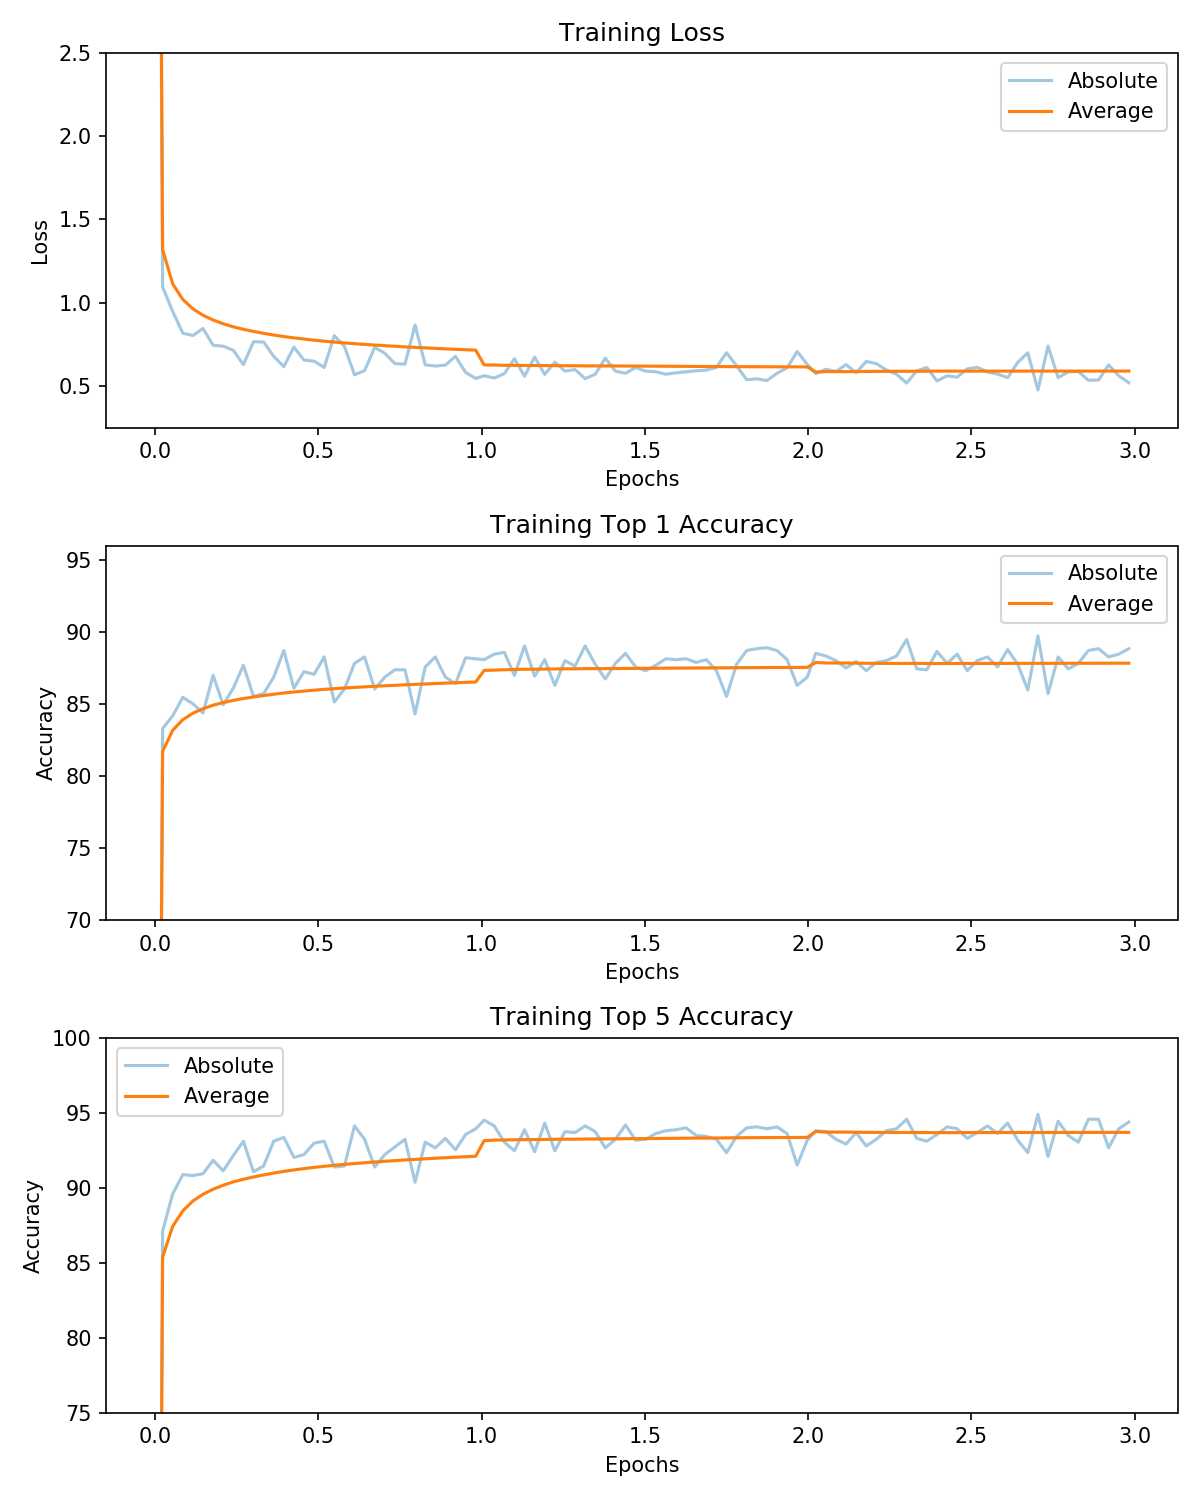

In [11]:
from plot import processing_logfile, plot

# Process the log file and get the necessary training and validation statistics data
train, validate, bleu = processing_logfile('logs/log_resnet101.txt')

#Plot the training statistics
fig, axes = plt.subplots(nrows=3, figsize=(8, 10))
ylims = [(0.25, 2.5), (70, 96), (75, 100)]
plot(fig, axes, train, 'Training', ylims)

### Analysis of Validation Statistics for Experiment 5

<IPython.core.display.Javascript object>


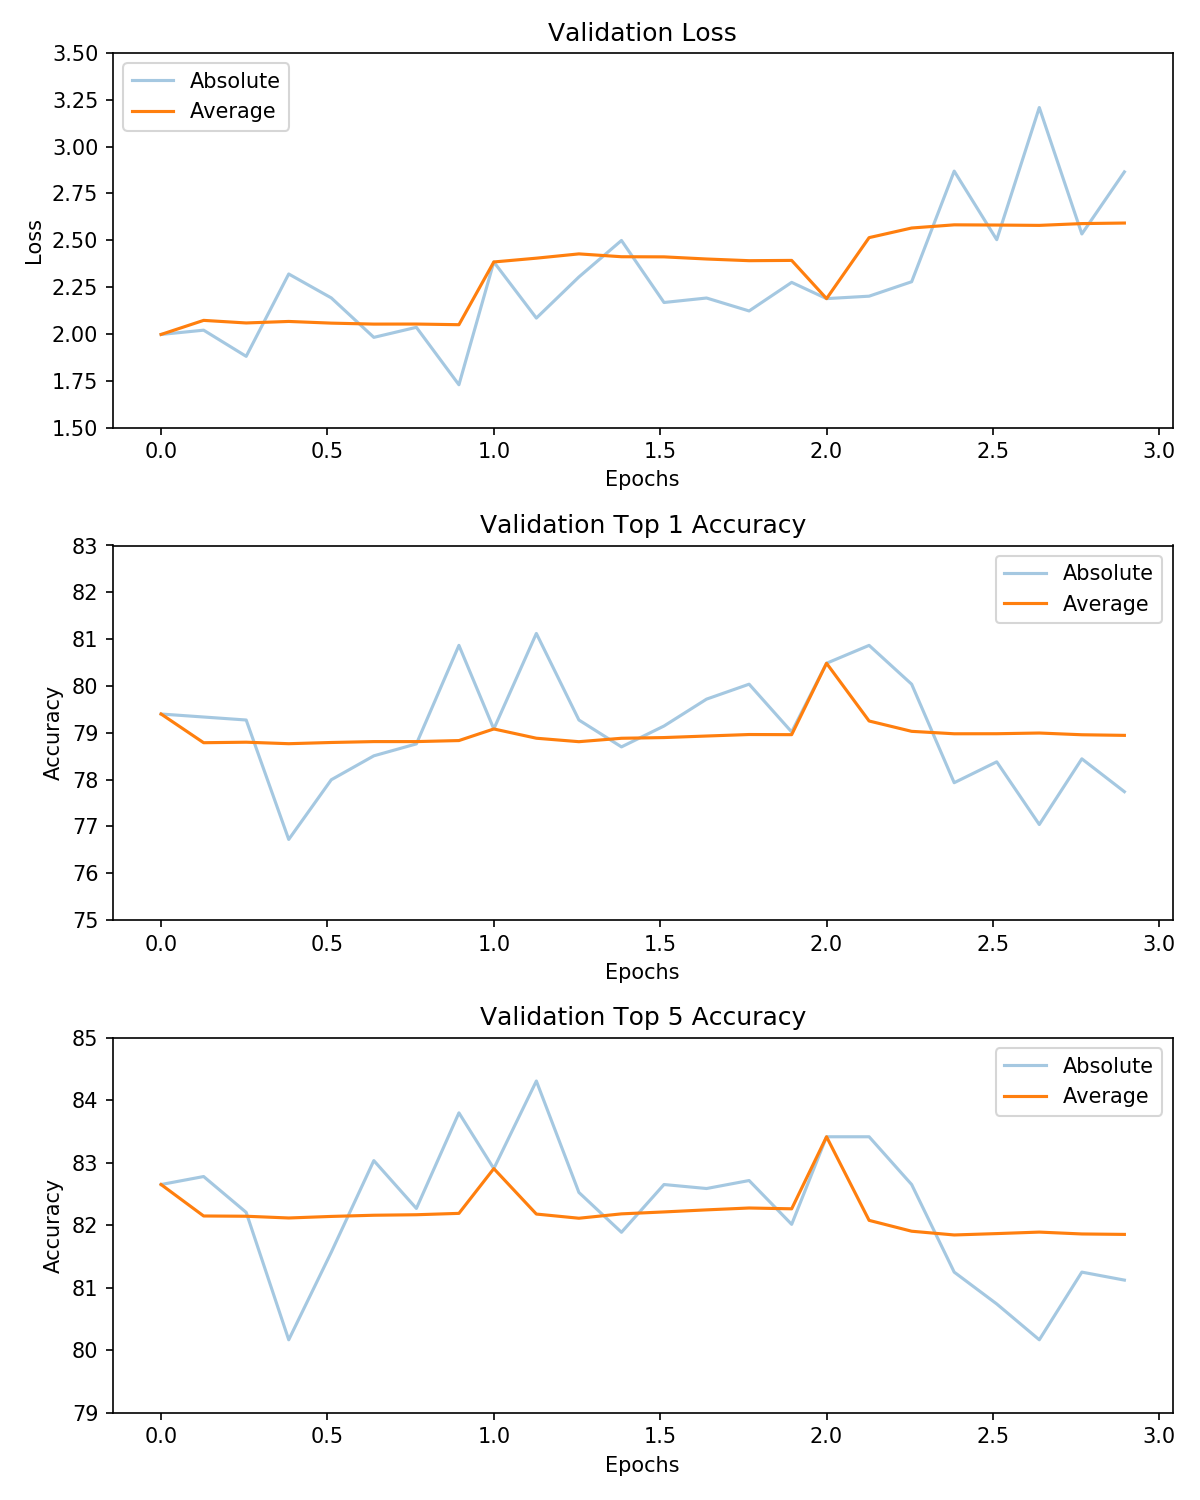

In [12]:
#Plot the validation statistics
fig, axes = plt.subplots(nrows=3, figsize=(8, 10))
ylims = [(1.5, 3.5), (75, 83), (79, 85)]
plot(fig, axes, validate, 'Validation', ylims)

### BLEU Scores for Experiment 5

In [13]:
# Bleu Scores for the Last Epoch
print(f'BLEU 1 Score on Validation Set: {bleu[2][0]}')
print(f'BLEU 2 Score on Validation Set: {bleu[2][1]}')
print(f'BLEU 3 Score on Validation Set: {bleu[2][2]}')
print(f'BLEU 4 Score on Validation Set: {bleu[2][3]}')

BLEU 1 Score on Validation Set: 0.7257612553708201
BLEU 2 Score on Validation Set: 0.5259332795460614
BLEU 3 Score on Validation Set: 0.377549558138997
BLEU 4 Score on Validation Set: 0.26479085537275154


### Analysis of Captions Produced by the Trained Network on the Testing Dataset

In [14]:
from generate_visualization import generate_caption_visualization, generate_image_caption

# Load the trained network (mainly the decoder into the decoder module)
encoder = Encoder(network)
decoder = Decoder(device, vocabulary_size, encoder.dim, tf_ratio = tf_ratio)

trained_model_path = 'models/model_resnet101.pth.tar'
decoder.load_state_dict(torch.load(trained_model_path)['state_dict'])

# Set the encoder and decoder in evaluation mode to get captions for testing data
encoder.eval()
decoder.eval()

test_img_paths = json.load(open(data_root_dir + '/test_img_paths.json'))

### Correctly Captioned Images

<IPython.core.display.Javascript object>


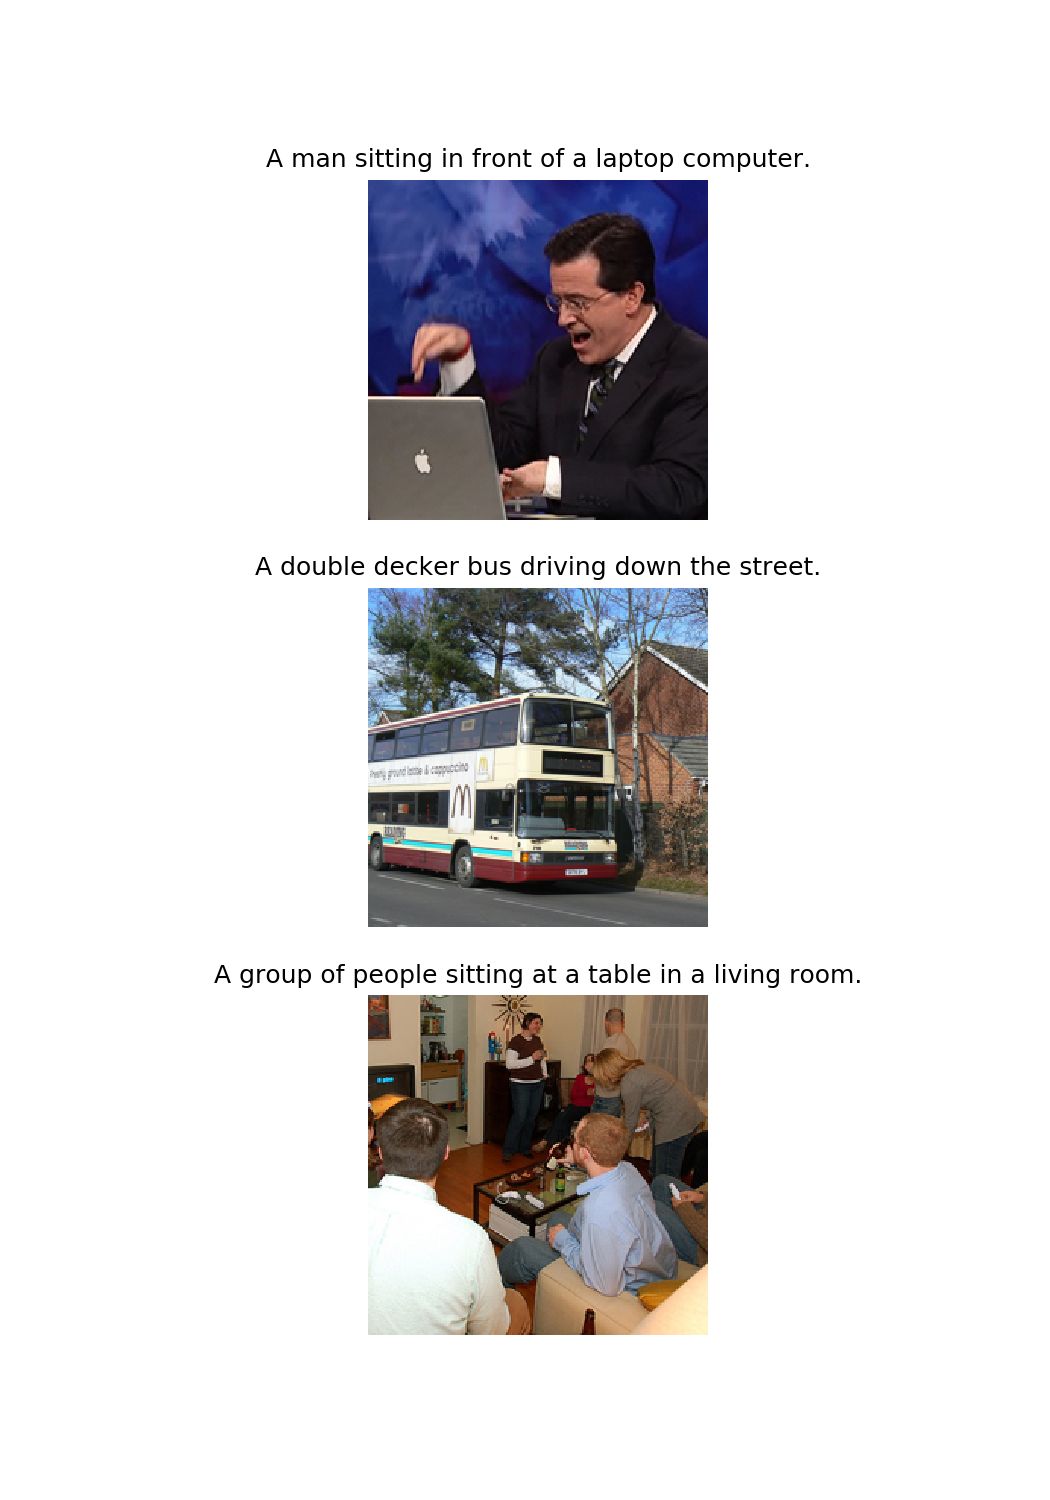

In [15]:
fig, axes = plt.subplots(nrows=3, figsize=(7,10))

generate_image_caption(encoder, decoder, data_root_dir +'/imgs'+test_img_paths['38822'], word_dict, beam_size=3, ax=axes[0])
generate_image_caption(encoder, decoder, data_root_dir +'/imgs'+test_img_paths['17691'], word_dict, beam_size=3, ax=axes[1])
generate_image_caption(encoder, decoder, data_root_dir +'/imgs'+test_img_paths['27450'], word_dict, beam_size=3, ax=axes[2])

### Incorrectly Captioned Images

<IPython.core.display.Javascript object>


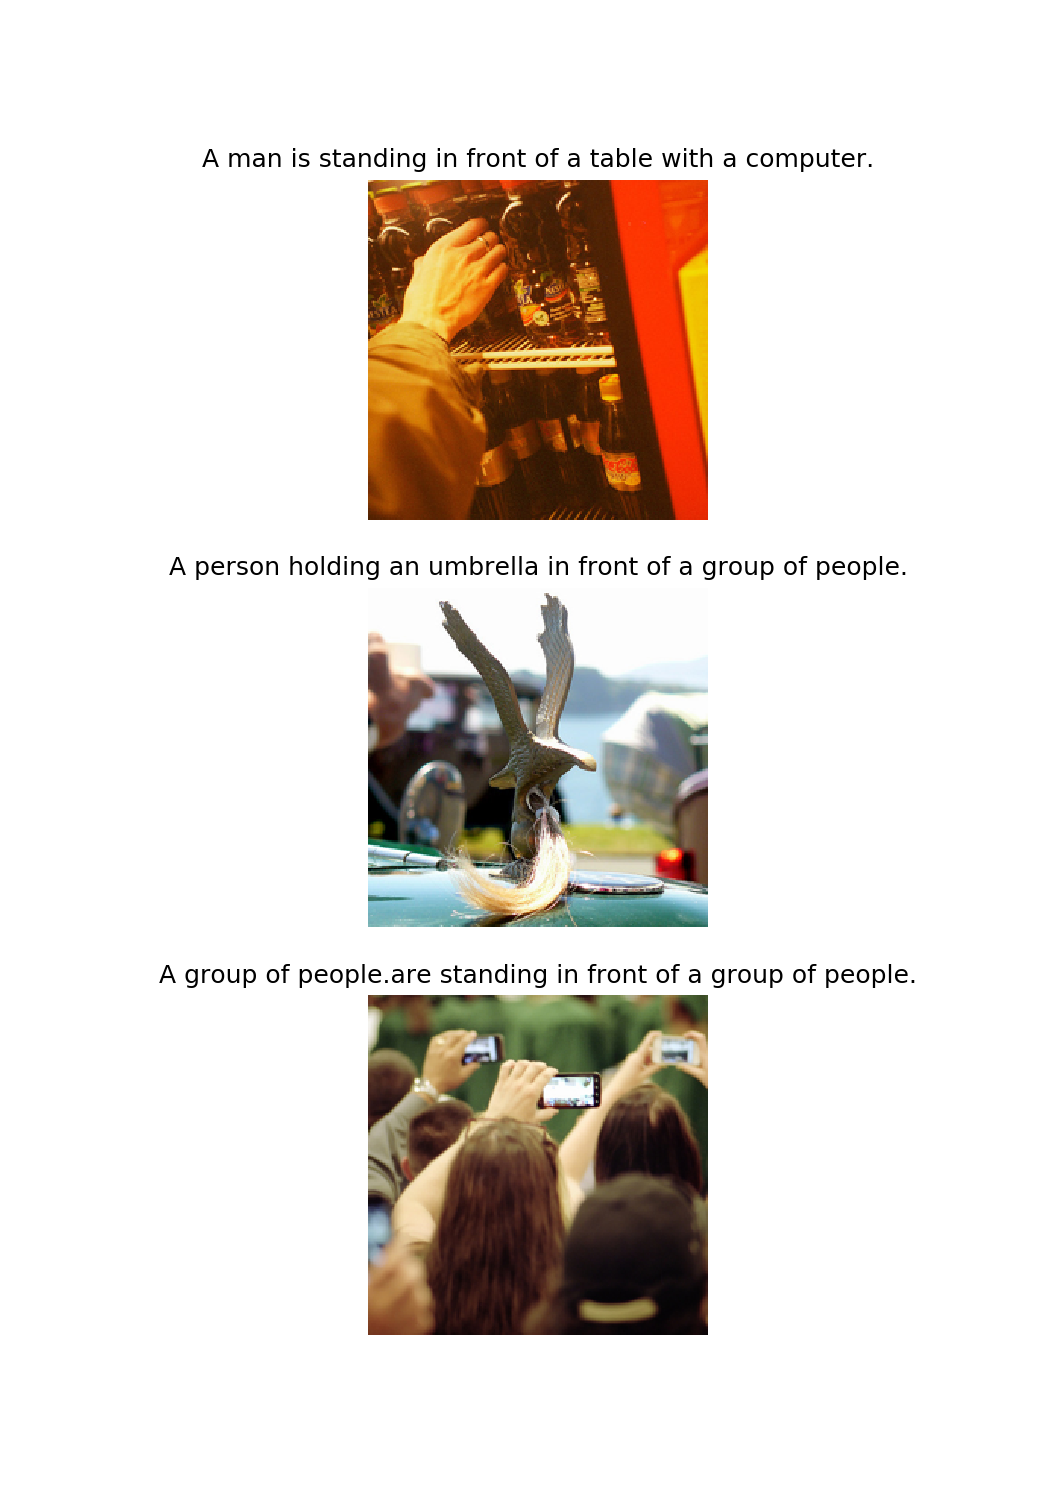

In [16]:
fig, axes = plt.subplots(nrows=3, figsize=(7,10))

generate_image_caption(encoder, decoder, data_root_dir +'/imgs'+test_img_paths['22456'], word_dict, beam_size=3, ax=axes[0])
generate_image_caption(encoder, decoder, data_root_dir +'/imgs'+test_img_paths['32828'], word_dict, beam_size=3, ax=axes[1])
generate_image_caption(encoder, decoder, data_root_dir +'/imgs'+test_img_paths['16300'], word_dict, beam_size=3, ax=axes[2])

Overall, the captions generated by this network capture the critical elements in the image. Also, the number of correctly captioned images has also improved using this network. However, a slight overfitting can be observed in cases where the network is unable to identify the objects within the image. It tends to use the more frequently occurring words to create a caption in these cases.

### Comparison of Epoch 1 Caption Vs Epoch 3 Caption

<IPython.core.display.Javascript object>


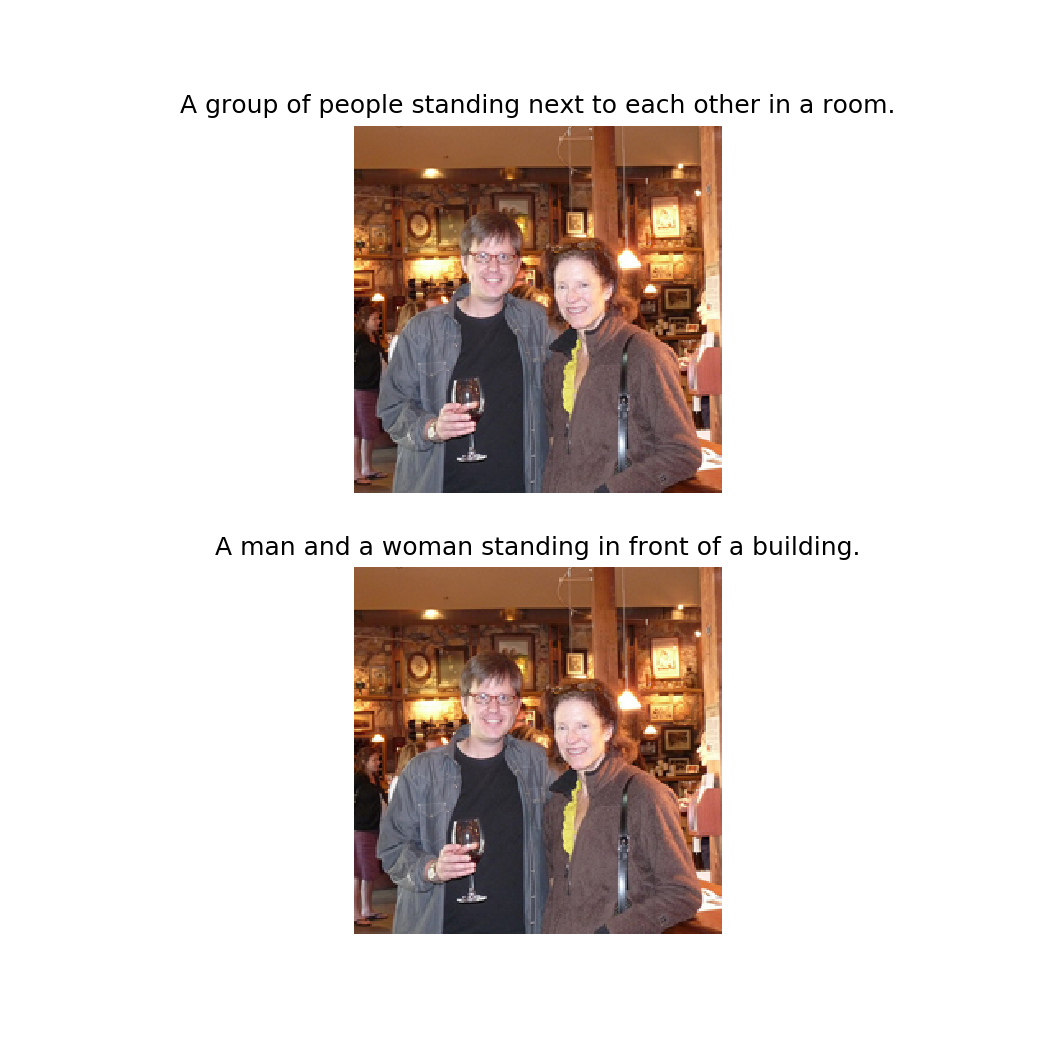

In [17]:
fig, axes = plt.subplots(nrows=2, figsize=(7,7))

# Load the trained network of epoch 1 (mainly the decoder into the decoder module)
encoder1 = Encoder(network)
decoder1 = Decoder(device, vocabulary_size, encoder.dim, tf_ratio = tf_ratio)

trained_model_path = 'models/model_resnet101_epoch1.pth.tar'
decoder1.load_state_dict(torch.load(trained_model_path)['state_dict'])

# Set the encoder and decoder in evaluation mode to get captions for testing data
encoder1.eval()
decoder1.eval()

generate_image_caption(encoder1, decoder1, data_root_dir +'/imgs'+test_img_paths['16375'], word_dict, beam_size=3, ax=axes[0])
generate_image_caption(encoder, decoder, data_root_dir +'/imgs'+test_img_paths['16375'], word_dict, beam_size=3, ax=axes[1])

Over the epochs, we can see the development of the caption and how it has become more specific in terms of its descriptions of the background and the people. Over the next few epochs, the network should be able to identify that there are two people in the image - a man and a woman and they are standing in a restaurant as against a building.